In [185]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

---

# Data

## Read

In [3]:
stat_mapping_df = pd.read_csv("data/Cac thong so.csv")
stat_mapping_df

,TT,Các thông số tính toán,0,1,2,3,4
0,1,Góc dốc địa hình (độ),<10,10-15,15-20,20-30,>30
1,2,Cao độ địa hình (m),<950,950-1000,1000-1200,1150-1200,>1200
2,3,Loại thạch học,Q,NaN,Trầm tích,Magma,Đá mạch
3,4,Khoảng cách đến đứt gãy (m),>400,200-400,100-200,50-100,<50
4,5,Khoảng cách đến ranh giới địa chất (m),>400,200-400,100-200,50-100,<50
5,6,Khoảng cách đến suối (m),>150,80-150,40-80,20-40,<20
6,7,Khoảng cách đến đường quốc lộ (m),>150,80-150,40-80,20-40,<20
7,8,Khoảng cách đến đường giao thông nội bộ (m),>150,80-150,40-80,20-40,<20
8,9,"Khoảng cách đến khối trượt lớn, điểm trượt (m)",>150,80-150,40-80,20-40,<20
9,10,Khoảng cách đến đường nhà dân dụng (m),>150,80-150,40-80,20-40,<20


In [4]:
have_landslide = pd.read_csv("data/CSDL_YenBai_CoTruot.csv")
no_landslide = pd.read_csv("data/CSDL_YenBai_KoTruot.csv")


## Check dupp

In [5]:
len1 = have_landslide["ma_moi"].unique().shape[0]
len2 = no_landslide["ma_moi"].unique().shape[0]

temp = np.unique(np.append(have_landslide["ma_moi"], no_landslide["ma_moi"]))

if (temp.shape[0] == len1 + len2):
    print("No dupps")

temp.shape


No dupps


(242906,)

## Concat data

In [6]:
df = pd.concat([have_landslide, no_landslide])
# df.to_csv("data/CSDL_YenBai_merged.csv", index=False) # uncomment if run this for the first time
del df, no_landslide, have_landslide

In [7]:
df = pd.read_csv("data/CSDL_YenBai_merged.csv")
df

,pointid,ma_cu,ma_moi,slope,elevation,thachhoc,dis_dutgay,dis_thachhoc,dis_river,dis_mainroad,dis_road,dis_dancu,output
0,1088835,1088835,1088835,5,4,4,3,4,1,4,0,3,1
1,1088840,1088840,1088840,5,4,4,3,4,1,4,0,2,1
2,1138568,1138568,1138568,2,4,4,0,0,1,0,2,0,1
3,1138579,1138579,1138579,2,4,4,0,0,1,0,2,0,1
4,1138595,1138595,1138595,2,4,4,0,0,1,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242901,1255809,1255809,1255809,4,4,4,0,0,0,0,1,0,0
242902,1255810,1255810,1255810,4,4,4,0,0,0,0,1,0,0
242903,1255811,1255811,1255811,3,4,4,0,0,0,0,1,0,0
242904,1255812,1255812,1255812,3,4,4,0,0,0,0,1,0,0


---

# Data EDA

In [8]:
temp1 = df.groupby("output").count()
px.bar(data_frame=temp1, x=temp1.index, y=temp1["pointid"], color="ma_cu")

In [33]:
subset_df = df.iloc[:, 3:-1]
subset_df

,slope,elevation,thachhoc,dis_dutgay,dis_thachhoc,dis_river,dis_mainroad,dis_road,dis_dancu
0,5,4,4,3,4,1,4,0,3
1,5,4,4,3,4,1,4,0,2
2,2,4,4,0,0,1,0,2,0
3,2,4,4,0,0,1,0,2,0
4,2,4,4,0,0,1,0,2,0
...,...,...,...,...,...,...,...,...,...
242901,4,4,4,0,0,0,0,1,0
242902,4,4,4,0,0,0,0,1,0
242903,3,4,4,0,0,0,0,1,0
242904,3,4,4,0,0,0,0,1,0


---

# Calculate Weights and CR 

In [10]:
manual_matrix = np.array([
    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
    [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
    [1/3, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
    [0.25, 1/3, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    [0.2, 0.25, 1/3, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0],
    [1/6, 0.2, 0.25, 1/3, 0.5, 1.0, 2.0, 3.0, 4.0],
    [1/7, 1/6, 0.2, 0.25, 1/3, 0.5, 1.0, 2.0, 3.0],
    [1/8, 1/7, 1/6, 0.2, 0.25, 1/3, 0.5, 1.0, 2.0],
    [1/9, 1/8, 1/7, 1/6, 0.2, 0.25, 1/3, 0.5, 1.0]
])



In [19]:
normalized_matrix = manual_matrix / np.sum(manual_matrix, axis=0)
normalized_matrix

array([[0.35348576, 0.42392127, 0.39510818, 0.34934498, 0.30706244,
        0.27169811, 0.24277457, 0.21917808, 0.2       ],
       [0.17674288, 0.21196064, 0.26340546, 0.26200873, 0.24564995,
        0.22641509, 0.20809249, 0.19178082, 0.17777778],
       [0.11782859, 0.10598032, 0.13170273, 0.17467249, 0.18423746,
        0.18113208, 0.1734104 , 0.16438356, 0.15555556],
       [0.08837144, 0.07065355, 0.06585136, 0.08733624, 0.12282497,
        0.13584906, 0.13872832, 0.1369863 , 0.13333333],
       [0.07069715, 0.05299016, 0.04390091, 0.04366812, 0.06141249,
        0.09056604, 0.10404624, 0.10958904, 0.11111111],
       [0.05891429, 0.04239213, 0.03292568, 0.02911208, 0.03070624,
        0.04528302, 0.06936416, 0.08219178, 0.08888889],
       [0.05049797, 0.03532677, 0.02634055, 0.02183406, 0.02047083,
        0.02264151, 0.03468208, 0.05479452, 0.06666667],
       [0.04418572, 0.03028009, 0.02195045, 0.01746725, 0.01535312,
        0.01509434, 0.01734104, 0.02739726, 0.04444444],


In [27]:
weights = np.mean(normalized_matrix, axis=1)
weights

array([0.3069526 , 0.21820376, 0.15432258, 0.10888162, 0.07644236,
       0.0533087 , 0.03702833, 0.02594597, 0.01891409])

In [26]:
sum_weights = np.dot(manual_matrix, weights)
lambda_max = np.sum(sum_weights / weights) / manual_matrix.shape[0]
lambda_max

9.407994217510485

In [30]:
CI = (lambda_max - manual_matrix.shape[0]) / (manual_matrix.shape[0]-1)
RI = 1.45

CR = CI / RI
CR


0.03517191530262799

=> The Matrix is consistency enough

---

In [ ]:
scaler = MinMaxScaler()
scaler.fit_transform(subset_df)


array([[1.  , 1.  , 1.  , ..., 1.  , 0.  , 0.75],
       [1.  , 1.  , 1.  , ..., 1.  , 0.  , 0.5 ],
       [0.4 , 1.  , 1.  , ..., 0.  , 0.5 , 0.  ],
       ...,
       [0.6 , 1.  , 1.  , ..., 0.  , 0.25, 0.  ],
       [0.6 , 1.  , 1.  , ..., 0.  , 0.25, 0.  ],
       [0.6 , 1.  , 1.  , ..., 0.  , 0.25, 0.  ]])

In [72]:
scaler = MinMaxScaler()
def calculate_lsi_and_risks(subset, weights):
    scaled_df = scaler.fit_transform(subset) 
    lsi = scaled_df @ weights.T
    
    min_lsi, max_lsi = lsi.min(), lsi.max()
    interval = (max_lsi - min_lsi) / 5 
    thresholds = [min_lsi + i * interval for i in range(1, 5)]
    print(thresholds)

    digits = np.digitize(lsi, thresholds)
    labels=['Rất thấp', 'Thấp', 'Trung bình', 'Cao', 'Rất cao']
 
    return [labels[i] for i in digits], lsi

risks, lsi = calculate_lsi_and_risks(subset_df, weights)

[0.2549080495338179, 0.41828622017970085, 0.5816643908255839, 0.7450425614714669]


In [73]:
df["Risk"] = risks
df["LSI"] = lsi
df

,pointid,ma_cu,ma_moi,slope,elevation,thachhoc,dis_dutgay,dis_thachhoc,dis_river,dis_mainroad,dis_road,dis_dancu,output,Risk,LSI
0,1088835,1088835,1088835,5,4,4,3,4,1,4,0,3,1,Rất cao,0.902124
1,1088840,1088840,1088840,5,4,4,3,4,1,4,0,2,1,Rất cao,0.897395
2,1138568,1138568,1138568,2,4,4,0,0,1,0,2,0,1,Trung bình,0.521608
3,1138579,1138579,1138579,2,4,4,0,0,1,0,2,0,1,Trung bình,0.521608
4,1138595,1138595,1138595,2,4,4,0,0,1,0,2,0,1,Trung bình,0.521608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242901,1255809,1255809,1255809,4,4,4,0,0,0,0,1,0,0,Cao,0.624575
242902,1255810,1255810,1255810,4,4,4,0,0,0,0,1,0,0,Cao,0.624575
242903,1255811,1255811,1255811,3,4,4,0,0,0,0,1,0,0,Trung bình,0.563184
242904,1255812,1255812,1255812,3,4,4,0,0,0,0,1,0,0,Trung bình,0.563184


---

In [110]:
def value_counts_dict(x):
    return x.value_counts().to_dict()

overall_stats = df.groupby("Risk").agg({
    "LSI" : ["min", "max", "count", "mean"],
    "output" : value_counts_dict
}).reset_index()

overall_stats.columns = ['_'.join(col).strip() for col in overall_stats.columns.values]

no_landslide_count = [overall_stats["output_value_counts_dict"].loc[i][0] for i in range(overall_stats.shape[0])]
landslide_count = [overall_stats["output_value_counts_dict"].loc[i][1] for i in range(overall_stats.shape[0])]

overall_stats["Landslide_count"] = landslide_count
overall_stats["No_landslide_count"] = no_landslide_count

overall_stats = overall_stats.drop(columns=["output_value_counts_dict"])
overall_stats = overall_stats.reindex([2, 3, 4, 0, 1])

In [111]:
overall_stats


,Risk_,LSI_min,LSI_max,LSI_count,LSI_mean,Landslide_count,No_landslide_count
2,Rất thấp,0.091530,0.254870,3874,0.211772,1,3873
3,Thấp,0.254976,0.418204,31492,0.356016,37,31455
4,Trung bình,0.418289,0.581635,85339,0.515481,1031,84308
0,Cao,0.581673,0.745021,114335,0.645459,892,113443
1,Rất cao,0.745058,0.908421,7866,0.780324,128,7738


In [155]:
color_map = px.colors.qualitative.Set1
color_dict = {risk: color_map[i % len(color_map)] for i, risk in enumerate(overall_stats["Risk_"].unique())}

# Map the colors based on the "Risk_" values
colors = overall_stats["Risk_"].map(color_dict)

In [156]:
stacked_trace = go.Bar(
    x=overall_stats['Risk_'],  # Risk levels
    y=overall_stats['Landslide_count'],  # Count of landslides
    name='Landslides',
    marker=dict(color='brown')
)

no_landslide_trace = go.Bar(
    x=overall_stats['Risk_'],  # Risk levels
    y=overall_stats['No_landslide_count'],  # Count of no landslides
    name='No Landslides',
    marker=dict(color='pink')
)

# Layout customization
layout = go.Layout(
    title="Landslide and No Landslide Counts by Risk Category",
    barmode='stack',  # Stack the bars
    xaxis=dict(title="Risk Category"),
    yaxis=dict(title="Count"),
    showlegend=True
)

# Create and show the figure
fig = go.Figure(data=[stacked_trace, no_landslide_trace], layout=layout)
fig.show()

In [135]:
# Create clustered bar plots for LSI Min, Max, and Mean by Risk Category
min_trace = go.Bar(
    x=overall_stats['Risk_'],  # Risk categories on the x-axis
    y=overall_stats['LSI_min'],  # LSI Min values
    name='LSI Min',  # Name for the first series
    marker=dict(color='purple')  # Color for LSI Min
)

max_trace = go.Bar(
    x=overall_stats['Risk_'],  # Risk categories on the x-axis
    y=overall_stats['LSI_max'],  # LSI Max values
    name='LSI Max',  # Name for the second series
    marker=dict(color='pink')  # Color for LSI Max
)

mean_trace = go.Bar(
    x=overall_stats['Risk_'],  # Risk categories on the x-axis
    y=overall_stats['LSI_mean'],  # LSI Mean values
    name='LSI Mean',  # Name for the third series
    marker=dict(color='brown')  # Color for LSI Mean
)

# Layout for the grouped bar chart
layout = go.Layout(
    title="LSI Min, Max, and Mean by Risk Category",
    barmode='group',  # Group the bars together
    xaxis=dict(title="Risk Category"),
    yaxis=dict(title="LSI Value"),
    showlegend=True  # Show legend
)

# Create and show the figure
fig = go.Figure(data=[min_trace, max_trace, mean_trace], layout=layout)
fig.show()


In [163]:
labels = overall_stats['Risk_']
landslide_counts = overall_stats['Landslide_count']
no_landslide_counts = overall_stats['No_landslide_count']

fig = make_subplots(rows=1, cols=2, specs=[[{"type":"pie"}] * 2])

landslide_pie = go.Pie(
        labels=labels,
        values=landslide_counts,
        name="Landslides",
        marker=dict(colors=colors),  # Color for each risk level  # Optional: makes it a donut chart
        title="Proportion of Landslides by Risk Level"
)
no_landslide_pie = go.Pie(
        labels=labels,
        values=no_landslide_counts,
        name="No Landslides",
        marker=dict(colors=colors),
        title="Proportion of No Landslides by Risk Level"
)

fig.add_trace(landslide_pie, row=1, col=1)
fig.add_trace(no_landslide_pie, row=1, col=2)


# Show the plot
fig.show()


In [162]:
px.pie(data_frame=overall_stats, names="Risk_", values="LSI_count",color_discrete_map=colors)

---

In [190]:
smt = SMOTE()
X_sm, Y_sm = smt.fit_resample(subset_df,df["output"])

X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size=0.2, random_state=192)

X_sm


,slope,elevation,thachhoc,dis_dutgay,dis_thachhoc,dis_river,dis_mainroad,dis_road,dis_dancu
0,5,4,4,3,4,1,4,0,3
1,5,4,4,3,4,1,4,0,2
2,2,4,4,0,0,1,0,2,0
3,2,4,4,0,0,1,0,2,0
4,2,4,4,0,0,1,0,2,0
...,...,...,...,...,...,...,...,...,...
481629,3,4,4,3,2,0,0,1,0
481630,2,1,3,2,4,1,1,3,1
481631,4,2,4,1,2,1,0,1,3
481632,4,3,3,2,2,2,0,3,3


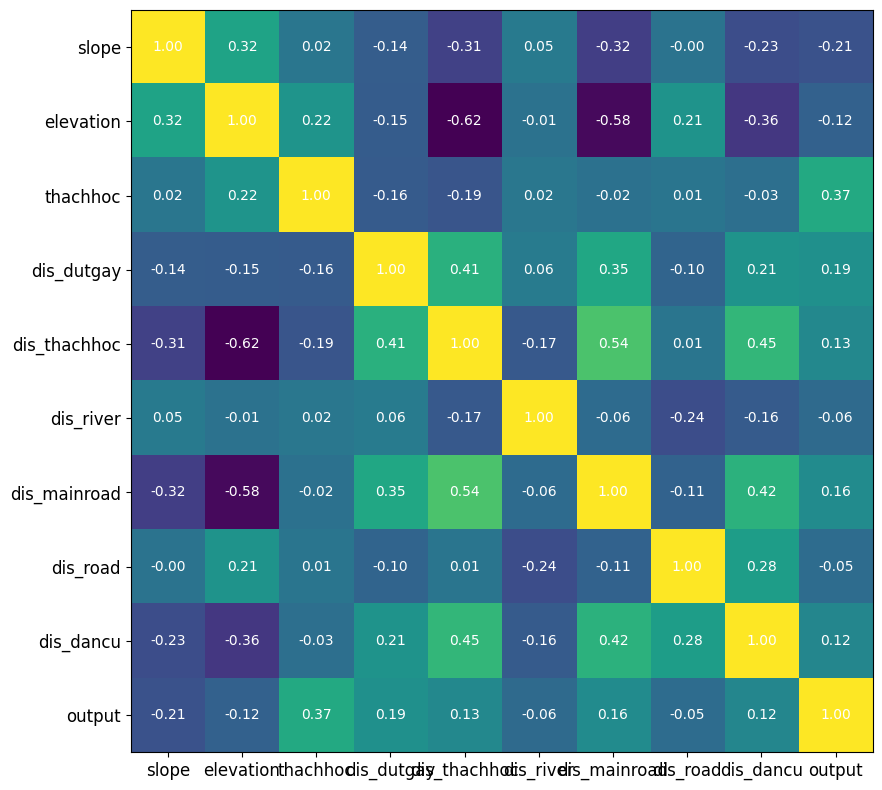

In [217]:
import matplotlib.pyplot as plt
temp = X_sm.copy(deep=True)
temp["output"] = Y_sm

corr_matrix = temp.corr()

plt.figure(figsize=(13, 8))

plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, fontsize=12)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns, fontsize=12)

# Hiển thị giá trị tương quan
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="white")

plt.tight_layout()

## Gaussian Naive Bayes

In [182]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [192]:
gnb_preds = gnb.predict(X_test) 
accuracy_score(y_test, gnb_preds)

print(classification_report(y_test, gnb_preds))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70     48198
           1       0.69      0.84      0.76     48129

    accuracy                           0.73     96327
   macro avg       0.74      0.73      0.73     96327
weighted avg       0.74      0.73      0.73     96327



## Logistic Regression

In [186]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

LogisticRegression()

In [193]:
lgr_preds = lgr.predict(X_test)
accuracy_score(y_test, lgr_preds)

print(classification_report(y_test, lgr_preds))

              precision    recall  f1-score   support

           0       0.78      0.70      0.73     48198
           1       0.72      0.80      0.76     48129

    accuracy                           0.75     96327
   macro avg       0.75      0.75      0.75     96327
weighted avg       0.75      0.75      0.75     96327



## Random Forest

In [188]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [194]:
rf_preds = rf.predict(X_test)
accuracy_score(y_test, rf_preds)

print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     48198
           1       0.97      0.99      0.98     48129

    accuracy                           0.98     96327
   macro avg       0.98      0.98      0.98     96327
weighted avg       0.98      0.98      0.98     96327

